##  Classical musical instrument classification task using Essentia Music Extractor, ML and DL techniques.

In [ ]:
import importlib.util
if importlib.util.find_spec('essentia') is None:
    !pip install essentia

!pip install mirdata
!pip install pandas

In [ ]:
#Basic imports
import os
import matplotlib.pyplot as plt
import numpy as np

# Imports to support MIR
import mirdata
import essentia.standard as ess
import pandas as pd


## Data processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
goodsounds = mirdata.initialize("good_sounds", data_home="/content/drive/MyDrive/MIR/good_sounds")
#goodsounds.download()
goodsounds.validate

In [ ]:
# Informations about the dataset
goodsounds_ids = goodsounds.track_ids  # Load IDs
goodsounds_data = goodsounds.load_tracks()  # Load  data
print('number of elements in the dataset:', len(goodsounds_ids))
# Visualize a random track
sound = goodsounds.choice_track()
print(f'Track id: {sound.track_id}')
print(f'Quality and/or articulation: {sound.klass}')
print(f'Intstrument: {sound.instrument}')



number of elements in the dataset: 16308
Track id: 18064
Quality and/or articulation: bad-richness-too-much-reed
Intstrument: oboe


In [ ]:
# Let's see all the quality/articulation classes 
klass_names = []
for i in goodsounds_ids:
    #not all sounds hava "klass"
    if goodsounds_data[i].klass == None:
      goodsounds_data[i].klass = 'None'
    klass_names.append(goodsounds_data[i].klass)
klass_names = np.unique(klass_names)
print(klass_names)

['' ' good-sound-pizzicato-hard' ' good-sound-pizzicato-soft' 'None'
 'air-inside' 'air-outside' 'bad-air' 'bad-attack'
 'bad-attack bad-richness' 'bad-attack bad-richness bad-timbre'
 'bad-attack bad-timbre bad-richness' 'bad-attack-air' 'bad-attack-gallo'
 'bad-attack-multiphonic' 'bad-attack-pitch-down' 'bad-attack-pitch-up'
 'bad-attack-pressure' 'bad-attack-rebond' 'bad-attack-tongue'
 'bad-attack-tongue-block' 'bad-attack-too-strong' 'bad-dynamic-stability'
 'bad-dynamics' 'bad-dynamics bad-timbre'
 'bad-dynamics-bad-timbre-bad-pitch' 'bad-dynamics-crescendo'
 'bad-dynamics-decrescendo' 'bad-dynamics-errors'
 'bad-dynamics-stability-crescendo' 'bad-dynamics-stability-decrescendo'
 'bad-dynamics-stability-errors' 'bad-dynamics-stability-tremolo'
 'bad-dynamics-tremolo' 'bad-pitch' 'bad-pitch bad-dynamics bad-timbre'
 'bad-pitch bad-timbre' 'bad-pitch bad-timbre bad richness'
 'bad-pitch-bad-timbre-notune' 'bad-pitch-errors' 'bad-pitch-stability'
 'bad-pitch-stability-bend' 'bad-pi

In [ ]:
# Before preprocess let's select the higher quality sounds in the dataset since we have seen that there are many sounds categorised as "bad"
# Let's create a dictonary using klass (Quality/articulation) as keys
klass_dict = {item: [] for item in klass_names}
for i in goodsounds_ids:
    klass_dict[goodsounds_data[i].klass].append(goodsounds_data[i])
#klass_dict['good-sound-bow'] #for example
# And select just enough of the good sounding samples
good_ones1 = klass_dict['good-sound']
print('good-sound lenght: ', len(good_ones1))
good_ones2 = klass_dict['good-sound-bow']
print('good-sound-bow: ', len(good_ones2))
good_ones = good_ones1 + good_ones2
del klass_dict
print(len(good_ones), 'are gonna be enough samples')




good-sound lenght:  2705
good-sound-bow:  80
2785 are gonna be enough samples


In [ ]:
# Since there are redundant sounds because are recorded with 3 different microphones, let's select just the neumann U87 ones.
microphones = []
for i in good_ones:
  microphones.append(i.microphone)
microphones = np.unique(microphones)
microphones_dict = {item: [] for item in microphones}
for i in good_ones:
  microphones_dict[i.microphone].append(i)
neumannU87 = microphones_dict['neumann'] # This is now our filtered dataset
del microphones_dict
# Let's create a dictonary using instrument as keys
instruments = []
for i in neumannU87:
  instruments.append(i.instrument)
instruments = np.unique(instruments)
print(f"We have the following intruments in the dataset: {instruments} ")
instruments_dict = {item: [] for item in instruments}
for i in neumannU87:
    instruments_dict[i.instrument].append(i.audio_path)
for key in instruments_dict.keys():
  print(f"In total there are {len(instruments_dict[key])} {key}")




We have the following intruments in the dataset: ['bass' 'cello' 'clarinet' 'flute' 'oboe' 'piccolo' 'sax_alto'
 'sax_baritone' 'sax_soprano' 'sax_tenor' 'trumpet' 'violin'] 
In total there are 80 bass
In total there are 99 cello
In total there are 219 clarinet
In total there are 244 flute
In total there are 62 oboe
In total there are 96 piccolo
In total there are 66 sax_alto
In total there are 100 sax_baritone
In total there are 66 sax_soprano
In total there are 66 sax_tenor
In total there are 87 trumpet
In total there are 141 violin


Plot waveforms of the first sample of each instrument:


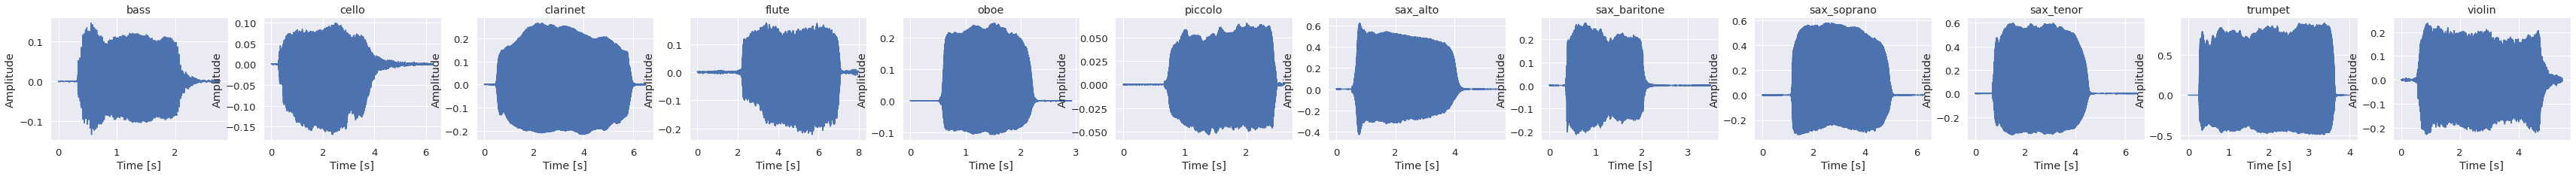

In [ ]:
# We plot the waveform of the first sound in each instrument category
_, fs = neumannU87[0].audio
num_sounds = len(instruments_dict.keys())
print("Plot waveforms of the first sample of each instrument:")
plt.figure(1, figsize=(5 * num_sounds, 3))
file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
for i, inst_name in enumerate(instruments_dict.keys()):
    sample_file = instruments_dict[inst_name][file_ind_inlist]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    t_max = len(x) / fs
    t = np.linspace(0, t_max, x.size)
    plt.subplot(1, num_sounds, (i+1))
    plt.plot(t, x)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title(inst_name)


## Preprocessing of raw data: Segmentation, splitting, alignment,... 

While common preprocessing steps (such as amplitude normalisation) exist, there is often some dataset and task specific preprocessing tasks required for grouping, cleaning, and format change. 

In the downloaded dataset, recordings include a sequence of isolated notes played in sequence which could be split into isolated notes. We would like to investigate the option of splitting using a fixed energy threshold (which would help us seperate notes using the silence regions). Let's define a function to perform this operation and visualize some samples to observe the effectiveness of it.

In [ ]:
# Raw-data preprocess analysis parameters
windowSize = 1024
hopSize = 512
NRG_threshold_ratio = 0.005 #threshold expressed as ratio with respect to the maximum value
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [ ]:
#Function definition
def split_file(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    
    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
    return (x, NRG, split_decision_func, start_indexes, stop_indexes)

Sample plots for waveform versus energy and splits based on energy threshold


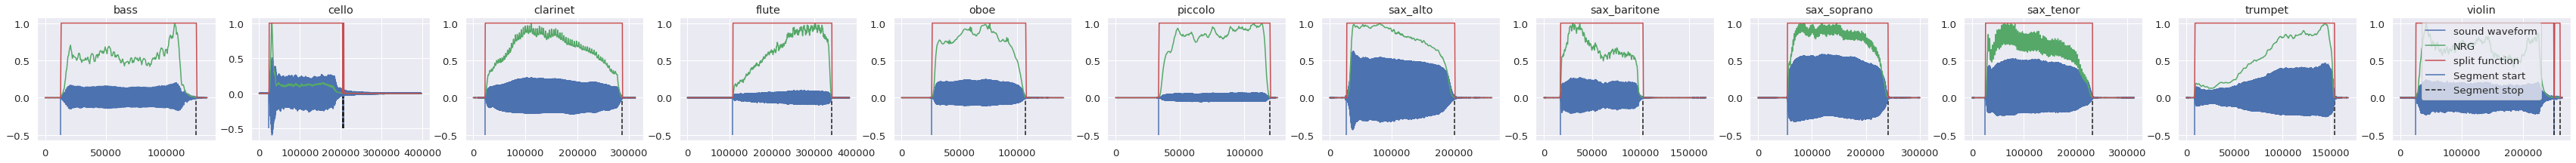

In [ ]:
num_instrument = len(instruments)
print("Sample plots for waveform versus energy and splits based on energy threshold")

file_indexes = [1]
for file_ind_inlist in file_indexes:
    plt.figure(file_ind_inlist, figsize=(5 * num_instrument, 3))
    for i, instrument in enumerate(instrument_dict.keys()):
        sample_file = instrument_dict[instrument][file_ind_inlist]
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        #Plotting functions for checking the split decisions
        plt.subplot(1,num_instrument,(i+1))
        plt.title(instrument)
        plt.plot(x, label = 'sound waveform')
        plt.plot(np.arange(NRG.size) * hopSize, NRG, 'g', label = 'NRG')
        plt.plot(np.arange(split_decision_func.size) * hopSize, split_decision_func,'r', label = 'split function')
        plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
        plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')

plt.legend(loc="best");


In [ ]:
#Create the directory for segmenting
main_data_dir = '/content/drive/MyDrive/MIR' #General directory, not in good sounds folder
if not os.path.exists(main_data_dir): 
    os.mkdir(main_data_dir)
segments_dir = os.path.join(main_data_dir,'segments')
if not os.path.exists(segments_dir):
    os.mkdir(segments_dir)

# Let's create segments and save them in segments folders with number of recording and name of the instrument
from pathlib import Path

segment_files = {item: [] for item in instruments}
for instrument, files in instruments_dict.items():
  for sample_file in files:
    #Get file ID
    sound_id = instrument + '_' + Path(sample_file).parts[-1]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
    #Croping segments
    for start, stop in zip(start_indexes, stop_indexes):
        x_seg = x[start: stop]
        #Final check for amplitude (to avoid silent segments selection due to noise in split function)
        if(np.max(np.abs(x_seg)) > 0.05):
            #Amplitude normalisation
            x_seg = x_seg / np.max(np.abs(x_seg))
            filename = os.path.join(segments_dir, sound_id)
            ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x_seg)
            segment_files[instrument].append(filename)

print('Done with segmenting')

Done with segmenting


## Feature extraction 

Let's compute a list of common features for each of the files and form a data frame including features and categories. We will be using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) that would compute a large number of features commonly used in MIR literature. 

Essentia-MusicExtractor extracts a large number of features. For simplicity, let's only keep low-level descriptors which are represented with a single scalar value as our feature set and discard other features.

In [ ]:
# Print descriptors to be considered
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(goodsounds_data['8757'].audio_path)

scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

Running musicextractor for all files, keeping a subset of features, writing to an output file: data.csv

In [ ]:
# Writing the features extracted in the data.csv file in the MIR folder
data_file = '/content/drive/MyDrive/MIR/data.csv'
file_count = 0
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['instrument']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for key in segment_files.keys():
      for filename in segment_files[key]:
          file_count +=1
          if file_count % 20 == 0: #print name of a file every 20 files
              print(file_count, "files processed, current file: ", filename)

          #Compute and write features for file
          features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                        lowlevelFrameSize = 2048,
                                                        lowlevelHopSize = 1024,
                                                        lowlevelStats = ['mean', 'stdev'])(filename)
          selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
          label = filename.split('/')[-1].split('.')[0].split('_')[0]
          line2write = str(selected_features)[1:-1] + ',' + label + '\n'
          writer.write(line2write)
print("A total of ", file_count, "files processed")




20 files processed, current file:  /content/drive/MyDrive/MIR/segments/bass_0019.wav
40 files processed, current file:  /content/drive/MyDrive/MIR/segments/bass_0039.wav
60 files processed, current file:  /content/drive/MyDrive/MIR/segments/bass_0059.wav
80 files processed, current file:  /content/drive/MyDrive/MIR/segments/cello_0000.wav
100 files processed, current file:  /content/drive/MyDrive/MIR/segments/cello_0020.wav
120 files processed, current file:  /content/drive/MyDrive/MIR/segments/cello_0008.wav
140 files processed, current file:  /content/drive/MyDrive/MIR/segments/cello_0028.wav
160 files processed, current file:  /content/drive/MyDrive/MIR/segments/cello_0049.wav
180 files processed, current file:  /content/drive/MyDrive/MIR/segments/clarinet_0002.wav
200 files processed, current file:  /content/drive/MyDrive/MIR/segments/clarinet_0022.wav
220 files processed, current file:  /content/drive/MyDrive/MIR/segments/clarinet_0042.wav
240 files processed, current file:  /cont

In [ ]:
#Read data with pandas module
data = pd.read_csv(data_file)

#Plot first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,instrument
0,0.990684,14.338331,2.222204,0.363002,0.039648,4.937138,2.330520,1.818885,0.505875,3.325045,...,51.317036,6.554051,1.896356,1880529.750,4.285924e+06,0.711374,0.256360,0.008324,0.001744,bass
1,0.976510,18.456923,2.229568,0.435657,0.058387,20.638475,7.225767,3.704280,0.756613,1.435648,...,40.286026,6.725509,2.659186,1065885.750,4.030407e+05,1.254802,0.496349,0.004189,0.000866,bass
2,0.990684,16.000315,1.121047,0.558366,0.072005,25.228899,10.061595,2.769510,0.772858,0.591848,...,49.408009,9.360132,1.881693,1607901.000,3.194893e+06,1.912025,0.700372,0.004464,0.001371,bass
3,0.970756,13.914619,1.266816,0.491827,0.059647,27.518101,7.988141,3.192551,0.455655,0.910050,...,82.149513,8.473980,2.242912,1683374.375,3.907790e+06,1.624065,0.498357,0.004517,0.001004,bass
4,0.974175,14.949003,0.985063,0.415720,0.033120,21.283152,4.502775,3.430627,0.391995,1.306215,...,34.261307,6.142035,1.505515,1629094.625,3.232434e+06,1.254020,0.364750,0.005252,0.001051,bass


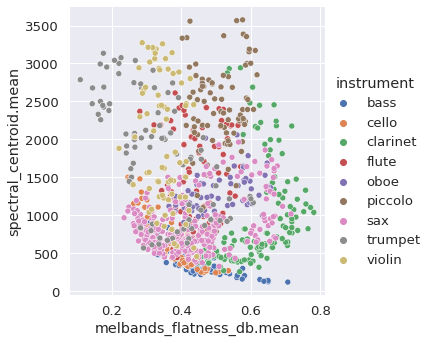

In [ ]:
# Take two random features and plot the sample points
import seaborn as sns
sns.relplot(x = "melbands_flatness_db.mean", y = "spectral_centroid.mean", hue = "instrument", data = data);

### Preprocessing of the features


In [ ]:
data_modif = data.copy()

#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,:84] = min_max_scaler.fit_transform(data.iloc[:,:84].values)

In [ ]:
# Checking if our data is balanced (if not, we should balance it to prevent our model to be baised)
data_modif.instrument.value_counts()

sax         298
flute       232
clarinet    209
violin      142
cello        98
trumpet      87
piccolo      85
bass         79
oboe         62
Name: instrument, dtype: int64

In [ ]:
# We choose oboe instead of "cha" to balance the number, since it's the smallest number 
min_number = data_modif.instrument.value_counts()['oboe']
sax_data = data_modif[data_modif.instrument == 'sax'].sample(n = min_number, random_state = 42)
flute_data = data_modif[data_modif.instrument == 'flute'].sample(n = min_number)
clarinet_data = data_modif[data_modif.instrument == 'clarinet'].sample(n = min_number)
violin_data = data_modif[data_modif.instrument == 'violin'].sample(n = min_number)
cello_data = data_modif[data_modif.instrument == 'cello'].sample(n = min_number)
trumpet_data = data_modif[data_modif.instrument == 'trumpet'].sample(n = min_number)
piccolo_data = data_modif[data_modif.instrument == 'piccolo'].sample(n = min_number)
oboe_data = data_modif[data_modif.instrument == 'oboe']
#Merging after downsampling
data_modif = pd.concat([sax_data, flute_data, clarinet_data, violin_data, cello_data, trumpet_data, piccolo_data, oboe_data])
#Checking the balance again
data_modif.instrument.value_counts()

sax         62
flute       62
clarinet    62
violin      62
cello       62
trumpet     62
piccolo     62
oboe        62
Name: instrument, dtype: int64

## Supervised learning approach (Support Vector Machines)

In [ ]:
# Input values put in a matrix, there are 84 features
X = data_modif.iloc[:,:84].values 
# Creating output values
data_modif.instrument = pd.Categorical(data_modif.instrument)  # convert to categorical data
y = np.array(data_modif.instrument.cat.codes)  # create label encoded outputs
# Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [8.98342839e-01 7.58109910e-02 1.85633685e-01 6.66561995e-02
 2.31955232e-01 4.73487984e-04 1.27333570e-03 1.64285442e-01
 2.55410256e-02 5.94307175e-01 3.84948084e-01 9.16032822e-01
 1.60011982e-01 3.02495828e-01 6.75116741e-02 1.99865174e-01
 1.58055448e-01 1.82621881e-01 8.13302097e-03 1.40601254e-02
 2.92714904e-01 1.05535553e-01 4.69693492e-01 2.34377076e-01
 3.20308690e-01 3.03018723e-01 2.66112024e-01 2.14662142e-01
 2.38443948e-01 4.36897277e-01 3.53431267e-01 2.14679385e-01
 6.78194466e-02 1.37542560e-01 2.32420237e-01 2.72611119e-01
 6.21069646e-03 1.09545473e-02 2.80573574e-01 3.02235038e-02
 4.50064756e-01 3.01780685e-01 8.60773953e-01 1.00830195e-01
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.01694919e-01 4.84187953e-01 2.61346756e-01 3.32362960e-01
 8.34192696e-01 8.40803167e-01 8.86605295e-01 9.69210942e-02
 1.17683839e-01 1.00235591e-01 1.00288215e-02 1.59772300e-02
 2.29781438e-03 1.76184214e-03 2.44344461e-01 2.190146

In [ ]:
# Let's split data into test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Check sizes of input and output vectors
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (332, 84) , Size of train output vector:  (332,)
Size of test features matrix:  (164, 84) , Size of test output vector:  (164,)


In [ ]:
# Define and train the model

from sklearn import svm
clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))

# Fit model with training data
clf.fit(X_train, y_train)

# Predict classes of test samples
y_pred = clf.predict(X_test)

In [ ]:
# Test the model
# Let's check for each sample in the test set if prediction matches the true class information
y_test == y_pred

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False,  True,  True,  True,  True,  True, False,  True, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False, False,

In [ ]:
# Data is balanced, so you can use accuracy as a measure:
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test), 'not bad accuracy')

accuracy:  0.8414634146341463 not bad accuracy


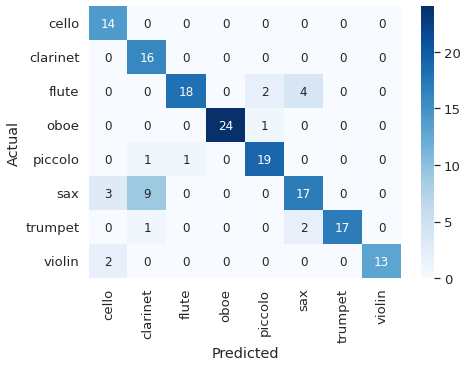

In [ ]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_modif.instrument)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

## Supervised learning approach (Neural Network)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Let's start by splitting our data 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

# ..and apply normalisation
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_train_val_onehot = onehot_encoder.fit_transform(y_train_val.reshape(len(y_train_val), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train_val shape = ", y_train_val_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

One-hot encoded y_train_val shape =  (396, 8)
One-hot encoded y_test shape =  (100, 8)


In [ ]:
from keras.models import Sequential
from keras import layers

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 40))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layer
    model.add(layers.Dense(name='HiddenLayer_2', units = 20))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 8))
    model.add(layers.Activation('sigmoid'))
    
    return model

model = compose_model(X_train_val.shape[1])

In [ ]:
model.summary()  # Plot summary of the model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (BatchNormalizat  (None, 84)               336       
 ion)                                                            
                                                                 
 HiddenLayer_1 (Dense)       (None, 40)                3400      
                                                                 
 batch_normalization_6 (Batc  (None, 40)               160       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 40)                0         
                                                                 
 dropout_6 (Dropout)         (None, 40)                0         
                                                                 
 HiddenLayer_2 (Dense)       (None, 20)               

In [ ]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train_val, y_train_val_onehot, batch_size = 50, epochs = 250, validation_split=0.2, verbose=0)

In [ ]:
score = model.evaluate(X_test, y_test_onehot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.037168558686971664
Test accuracy: 0.9599999785423279


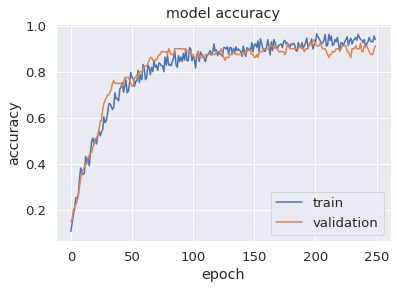

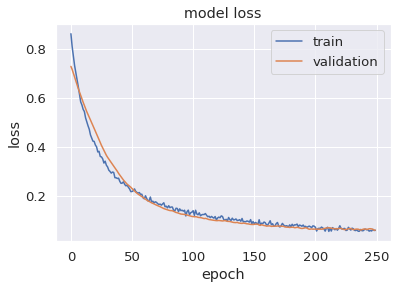

In [ ]:
# summarize history for accuracy
plt.plot(summary.history['accuracy'])
plt.plot(summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Install libraries

In [1]:
!pip install pandas
!pip install seaborn
!pip install sklearn
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=c4c280c20b583f391a9ca2ee8e74e4ad7afea7ccb2ff73c8cc80437a46f54595
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: f

In [2]:
# We'll need numpy and pandas for basic data wrangling
import numpy as np
import pandas as pd

# We'll need matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# We'll use some preprocessing from scikit-learn:
#  Standard scaling (z-scoring) and label encoding
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Our classifier will be 1-nearest-neighbor after learning the distance metric
from sklearn.neighbors import KNeighborsClassifier

# Pipelines make it a little easier to manage sequences of models,
# eg scaler -> metric learner -> 1nn
from sklearn.pipeline import make_pipeline

# We'll use some standard machinery for reporting accuracy of our models
from sklearn.metrics import classification_report,  plot_confusion_matrix

from sklearn.model_selection import train_test_split


RNG_STATE = 0

from google.colab import files


## Data loading

Please upload the data.csv file generated previously. 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_file = '/content/drive/MyDrive/MIR/data.csv'

#uploaded = files.upload()

#Read data with pandas module

data = pd.read_csv(data_file)

#Plot first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,instrument
0,0.990684,14.338331,2.222204,0.363002,0.039648,4.937138,2.330520,1.818885,0.505875,3.325045,...,51.317036,6.554051,1.896356,1880529.750,4.285924e+06,0.711374,0.256360,0.008324,0.001744,bass
1,0.976510,18.456923,2.229568,0.435657,0.058387,20.638475,7.225767,3.704280,0.756613,1.435648,...,40.286026,6.725509,2.659186,1065885.750,4.030407e+05,1.254802,0.496349,0.004189,0.000866,bass
2,0.990684,16.000315,1.121047,0.558366,0.072005,25.228899,10.061595,2.769510,0.772858,0.591848,...,49.408009,9.360132,1.881693,1607901.000,3.194893e+06,1.912025,0.700372,0.004464,0.001371,bass
3,0.970756,13.914619,1.266816,0.491827,0.059647,27.518101,7.988141,3.192551,0.455655,0.910050,...,82.149513,8.473980,2.242912,1683374.375,3.907790e+06,1.624065,0.498357,0.004517,0.001004,bass
4,0.974175,14.949003,0.985063,0.415720,0.033120,21.283152,4.502775,3.430627,0.391995,1.306215,...,34.261307,6.142035,1.505515,1629094.625,3.232434e+06,1.254020,0.364750,0.005252,0.001051,bass


Train test splitting using sklearn

In [6]:
X_train, X_test, y_train_text, y_test_text = train_test_split(data[data.columns[:-1]],data[data.columns[-1]], test_size=0.2, random_state=RNG_STATE)

We need to encode the output labels as numbers, to have them as targets for machine learning models. 

In [7]:
# We'll need to use a label encoder to encode our instrument
# names as numeric identifiers (0, 1, 2, ..., 9)
encoder = LabelEncoder()

# "Fit" on the training labels; this is really just specifying our vocabulary
# transform maps the encoding over the list of strings to give our encoded label array
y_train = encoder.fit_transform(y_train_text)

# Since the encoder is already fit, we can now transform our test set labels as well
y_test = encoder.transform(y_test_text)

## Feature pre-processing and classification

We use a StandardScaler to do a feature normalization such as the input features have a mean zero and standard deviation 1. 
We then build a pipeline chaining the feature pre-processing and the classifier, in this case a KNN 

              precision    recall  f1-score   support

        bass       0.87      0.72      0.79        18
       cello       0.73      0.73      0.73        11
    clarinet       1.00      0.95      0.97        39
       flute       0.94      1.00      0.97        51
        oboe       1.00      1.00      1.00        10
     piccolo       0.87      0.93      0.90        14
         sax       0.97      1.00      0.99        68
     trumpet       1.00      1.00      1.00        13
      violin       0.97      0.94      0.96        35

    accuracy                           0.95       259
   macro avg       0.93      0.92      0.92       259
weighted avg       0.95      0.95      0.95       259



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


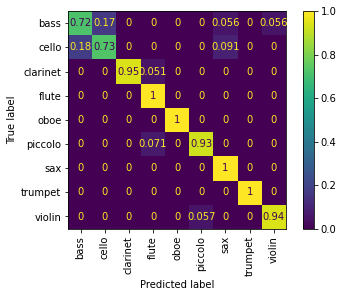

In [8]:
# Our classifier is a "pipeline": scaling followed by KNN
clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))

# Fit all stages of the pipeline to our training data
clf.fit(X_train, y=y_train)

# How well does our 1-Nearest neighbor model work?
y_pred = clf.predict(X_test)

# Compare our predictions to the true labels in y_test
report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

# Finally, plot a confusion matrix showing how mistakes are distributed
plot_confusion_matrix(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

## Feature visualization

In [9]:
### How to visualize features using metric learning https://github.com/bmcfee/ismir2020-metric-learning
# scikit-learn provides Linear discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Finally, umap will let us map high-dimensional data down to 2-d for plotting
import umap

We visualize the data by applying a transformation using UMAP from a high dimensional space to a low dimensional space. Similarly to the PCA reduction, the output axes do not hold any specific meaning.

In [10]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll apply all but the last stage (KNN classifier) of our pipeline to the data.
# In this case, we just have one previous stage, which does feature normalization.
# This will change in subsequent examples.

X_train_transformed = clf[:-1].transform(X_train)
X_test_transformed = clf[:-1].transform(X_test)

# Fit on the transformed data, and then transform the test data
embed = reducer.fit_transform(X_train_transformed)
embed_test = reducer.transform(X_test_transformed)

In the plot the different classes are plotted with different colors, while the train and test datasets are denoted by x or circles.
If the test and training data of the same color appear near each other in the visualization, then nearest neighbor classification should work well.

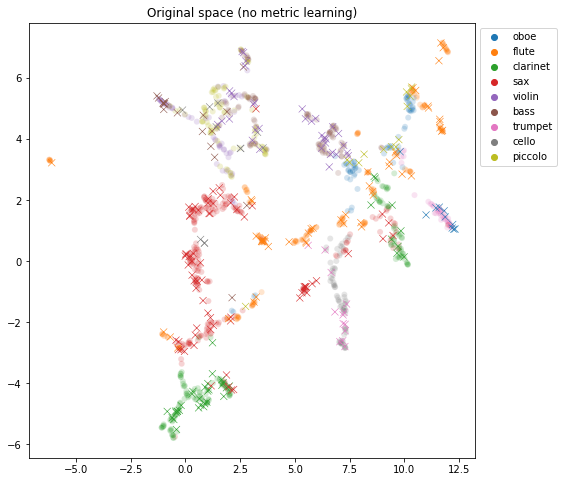

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train_text, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test_text, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Original space (no metric learning)');

## Linear projection of features

We use Linear Discriminant Analysis to better separate the classes by learning a 9-dimensional projection of the features. 

[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.0s
[Pipeline]  (step 2 of 3) Processing lineardiscriminantanalysis, total=   0.0s
[Pipeline]  (step 3 of 3) Processing kneighborsclassifier, total=   0.0s
              precision    recall  f1-score   support

        bass       1.00      0.94      0.97        18
       cello       0.92      1.00      0.96        11
    clarinet       0.91      1.00      0.95        39
       flute       1.00      1.00      1.00        51
        oboe       1.00      1.00      1.00        10
     piccolo       1.00      1.00      1.00        14
         sax       1.00      0.94      0.97        68
     trumpet       1.00      1.00      1.00        13
      violin       1.00      1.00      1.00        35

    accuracy                           0.98       259
   macro avg       0.98      0.99      0.98       259
weighted avg       0.98      0.98      0.98       259



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


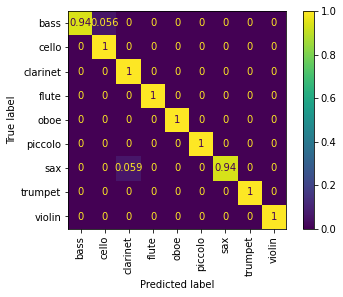

In [12]:
clf = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(), KNeighborsClassifier(n_neighbors=1), verbose=True)
clf.fit(X_train, y=y_train)

y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

plot_confusion_matrix(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

Let's visualize the results: 

In [13]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll fit the umap embedding on the data after applying our learned transformation
embed = reducer.fit_transform(clf[:-1].transform(X_train))
embed_test = reducer.transform(clf[:-1].transform(X_test))

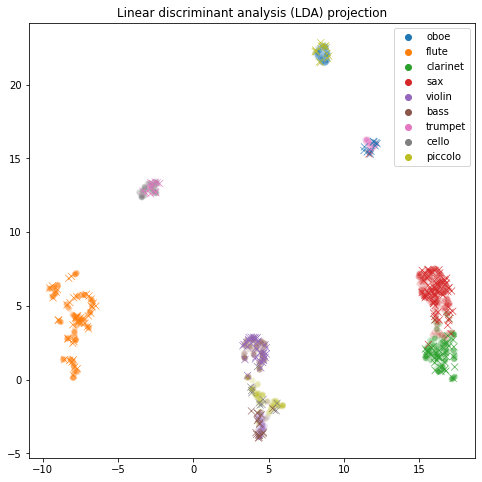

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train_text, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test_text, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Linear discriminant analysis (LDA) projection');

The projection learned by LDA tells us the weight assigned to each of the training features. 

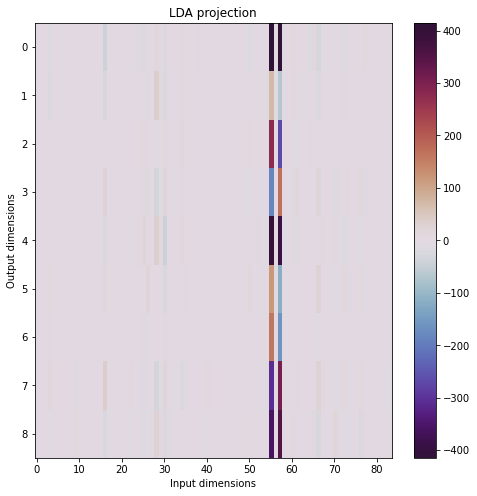

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
model = clf.steps[1][1]
weights = model.coef_

img = ax.imshow(weights, cmap='twilight_shifted', vmin=-np.abs(weights).max(), vmax=np.abs(weights).max(), aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax)
ax.grid(False)
ax.set(xlabel='Input dimensions', ylabel='Output dimensions', title='LDA projection');

Which features are given more importance? 

In [16]:
for i in range(len(weights)):
  print(data.columns[:-1][weights[0]>100])

Index(['spectral_energy.stdev'], dtype='object')
Index(['spectral_energy.stdev'], dtype='object')
Index(['spectral_energy.stdev'], dtype='object')
Index(['spectral_energy.stdev'], dtype='object')
Index(['spectral_energy.stdev'], dtype='object')
Index(['spectral_energy.stdev'], dtype='object')
Index(['spectral_energy.stdev'], dtype='object')
Index(['spectral_energy.stdev'], dtype='object')
Index(['spectral_energy.stdev'], dtype='object')
